In [38]:
import numpy as np
import datetime
from dateutil.relativedelta import relativedelta
import holidays
import matplotlib.pyplot as plt
from scipy.interpolate import CubicSpline
from scipy.stats import norm

In [8]:
class USCalendar:
    def __init__(self):
        self.country='US'
    def check_if_date_is_country_holiday(self,date):
        return (date in holidays.US(years=date.year))
    def check_if_date_is_weekend(self,date):
        return (date.weekday()>=5)
    def make_date_not_holiday(self,date):
        while (self.check_if_date_is_country_holiday(date) or self.check_if_date_is_weekend(date)):
            date+=datetime.timedelta(days=1)
        return date
    def add(self,date,days=0, months=0, years=0,MakeNotHolidayFirst=True,MakeNotHolidayLast=True):
        #print(date, days, months, years)
        if (MakeNotHolidayFirst):
            date=self.make_date_not_holiday(date)
        date+=relativedelta(years=years,months=months,days=days)
        #print("new date=",date)
        if (MakeNotHolidayLast):
            date=self.make_date_not_holiday(date)
        return date
    
    
    
class RatesCurve:
    def __init__(self,name,DayCountConvention,Interpolation,now):
        self.name=name
        self.DayCountConvention=DayCountConvention
        self.Interpolation=Interpolation
        self.now=now
        self.Dates=[now]
        self.DiscFactors={self.Dates[0]:1.0}
    def add_date_and_DiscFactor(self,date, DiscFactor):
        if (date < self.Dates[-1]):
            raise RuntimeError('You may add new DiscFactors only to the very end of the curve!',date,'is not greater than',self.Dates[-1])
        else:
            self.Dates.append(date)
            self.DiscFactors[date]=DiscFactor
    def get_disc_factor_now_T(self,date):
        if date < self.now:
            raise RuntimeError('Date',date,' is in the past!')
        elif date > self.Dates[-1]:
            raise RuntimeError('Date', date,' is greater than the last date of the constructed curve!')
        elif date==self.Dates[0]:
            return self.DiscFactors[self.Dates[0]]
        else:
            i=0
            while (date > self.Dates[i]):
                i+=1
            ti=self.Dates[i]
            tim1=self.Dates[i-1]
            #print(tim1,ti,self.DiscFactors[tim1],self.DiscFactors[ti])
            ln_DFti=np.log(self.DiscFactors[ti])
            ln_DFtim1=np.log(self.DiscFactors[tim1])
            x=(date-self.now).days/360
            xp=[(tim1-self.now).days/360,(ti-self.now).days/360]
            fp=[ln_DFtim1,ln_DFti]
            #print(x,xp,fp, np.exp(np.interp(x,xp,fp)))
            return np.exp(np.interp(x,xp,fp))
    def get_disc_factor_t_T(self,date_t, date_T):
        return self.get_disc_factor_now_T(date_T)/self.get_disc_factor_now_T(date_t)
            
        
class InterestRatesSwapProduct:
    #даты платежей - уже должны быть в BD-календаре
    def __init__(self, now, name,
                 Leg1IndexIdentifier, #инфо
                 Leg1Tenor, #(days,months,years)
                 Leg1StartDateLagInDays, #timedelta
                 Leg1PaymentLagInDays, #инфо
                 Leg1FloatingRateSpread, 
                 Leg1FixedRate, 
                 Leg1DayCountConvention, #инфо
                 Leg1IsFixed,
                 Leg1Frequency,
                 Leg2IndexIdentifier, #инфо
                 Leg2Tenor,
                 Leg2StartDateLagInDays,
                 Leg2PaymentLagInDays, #инфо
                 Leg2FloatingRateSpread, 
                 Leg2FixedRate, 
                 Leg2DayCountConvention,
                 Leg2IsFixed,
                 Leg2Frequency): #инфо
        self.now=now
        self.name=name
        self.Leg1Frequency=Leg1Frequency
        MyCalendar=USCalendar()
        now=MyCalendar.make_date_not_holiday(now)
                 
        tek_period_start_date=MyCalendar.add(now, days=Leg1StartDateLagInDays)
        Leg1AbsEndDate=MyCalendar.add(tek_period_start_date, days=Leg1Tenor[0],months=Leg1Tenor[1],years=Leg1Tenor[2])
        #print("f",Leg1AbsEndDate)
        self.Leg1PeriodStartDates=[]
        if (self.Leg1Frequency=='1Y'):
            while (len(self.Leg1PeriodStartDates)==0 or MyCalendar.add(tek_period_start_date,years=1,MakeNotHolidayFirst=False,MakeNotHolidayLast=False)<=Leg1AbsEndDate):
                #print("g",tek_period_start_date)
                self.Leg1PeriodStartDates.append(MyCalendar.make_date_not_holiday(tek_period_start_date))
                tek_period_start_date=MyCalendar.add(tek_period_start_date,years=1,MakeNotHolidayFirst=False,MakeNotHolidayLast=False)
        elif (self.Leg1Frequency=='3M'):
            while (len(self.Leg1PeriodStartDates)==0 or MyCalendar.add(tek_period_start_date,months=3,MakeNotHolidayFirst=False,MakeNotHolidayLast=False)<=Leg1AbsEndDate):
                #print("g",tek_period_start_date)
                self.Leg1PeriodStartDates.append(MyCalendar.make_date_not_holiday(tek_period_start_date))
                tek_period_start_date=MyCalendar.add(tek_period_start_date,months=3,MakeNotHolidayFirst=False,MakeNotHolidayLast=False)
        elif (self.Leg1Frequency=='6M'):
            while (len(self.Leg1PeriodStartDates)==0 or MyCalendar.add(tek_period_start_date,months=6,MakeNotHolidayFirst=False,MakeNotHolidayLast=False)<=Leg1AbsEndDate):
                #print("g",tek_period_start_date)
                self.Leg1PeriodStartDates.append(MyCalendar.make_date_not_holiday(tek_period_start_date))
                tek_period_start_date=MyCalendar.add(tek_period_start_date,months=6,MakeNotHolidayFirst=False,MakeNotHolidayLast=False)
                
        tek_period_end_date= Leg1AbsEndDate
        #print("h",tek_period_end_date)
        self.Leg1PeriodEndDates=[]
        if (self.Leg1Frequency=='1Y'):
            while (len(self.Leg1PeriodEndDates)==0 or MyCalendar.add(tek_period_end_date,years=-1,MakeNotHolidayFirst=False,MakeNotHolidayLast=False)>=MyCalendar.add(now, days=Leg1StartDateLagInDays)):
                #print("i",tek_period_end_date)
                #print(MyCalendar.add(tek_period_end_date,datetime.timedelta(days=-360)),MyCalendar.add(now, Leg1StartDateLagInDays))
                self.Leg1PeriodEndDates.append(MyCalendar.make_date_not_holiday(tek_period_end_date))
                tek_period_end_date=MyCalendar.add(tek_period_end_date,years=-1,MakeNotHolidayFirst=False,MakeNotHolidayLast=False)   
        elif (self.Leg1Frequency=='3M'):
            while (len(self.Leg1PeriodEndDates)==0 or MyCalendar.add(tek_period_end_date,months=-3,MakeNotHolidayFirst=False,MakeNotHolidayLast=False)>=MyCalendar.add(now, days=Leg1StartDateLagInDays)):
                #print("i",tek_period_end_date)
                #print(MyCalendar.add(tek_period_end_date,datetime.timedelta(days=-360)),MyCalendar.add(now, Leg1StartDateLagInDays))
                self.Leg1PeriodEndDates.append(MyCalendar.make_date_not_holiday(tek_period_end_date))
                tek_period_end_date=MyCalendar.add(tek_period_end_date,months=-3,MakeNotHolidayFirst=False,MakeNotHolidayLast=False)
        elif (self.Leg1Frequency=='6M'):
            while (len(self.Leg1PeriodEndDates)==0 or MyCalendar.add(tek_period_end_date,months=-6,MakeNotHolidayFirst=False,MakeNotHolidayLast=False)>=MyCalendar.add(now, days=Leg1StartDateLagInDays)):
                #print("i",tek_period_end_date)
                #print(MyCalendar.add(tek_period_end_date,datetime.timedelta(days=-360)),MyCalendar.add(now, Leg1StartDateLagInDays))
                self.Leg1PeriodEndDates.append(MyCalendar.make_date_not_holiday(tek_period_end_date))
                tek_period_end_date=MyCalendar.add(tek_period_end_date,months=-6,MakeNotHolidayFirst=False,MakeNotHolidayLast=False)                 
                
        self.Leg1PeriodEndDates=self.Leg1PeriodEndDates[::-1]  

        self.Leg1PaymentDates=list(map(lambda x: MyCalendar.add(x,days=Leg1PaymentLagInDays),self.Leg1PeriodEndDates))
        self.Leg1Tenor=Leg1Tenor
        self.Leg1StartDateLagInDays=Leg1StartDateLagInDays
        self.Leg1PaymentLagInDays=Leg1PaymentLagInDays
        self.Leg1IndexIdentifier=Leg1IndexIdentifier
        self.Leg1FloatingRateSpread=Leg1FloatingRateSpread
        self.Leg1FixedRate=Leg1FixedRate
        self.Leg1DayCountConvention=Leg1DayCountConvention
        self.Leg1IsFixed=Leg1IsFixed
        
        
        self.Leg2Frequency=Leg2Frequency
        tek_period_start_date=MyCalendar.add(now, days=Leg2StartDateLagInDays)
        Leg2AbsEndDate=MyCalendar.add(tek_period_start_date, days=Leg2Tenor[0],months=Leg2Tenor[1],years=Leg2Tenor[2])
        #print("f",Leg1AbsEndDate)
        self.Leg2PeriodStartDates=[]
        if (self.Leg2Frequency=='1Y'):
            while (len(self.Leg2PeriodStartDates)==0 or MyCalendar.add(tek_period_start_date,years=1,MakeNotHolidayFirst=False,MakeNotHolidayLast=False)<=Leg2AbsEndDate):
                #print("g",tek_period_start_date)
                self.Leg2PeriodStartDates.append(MyCalendar.make_date_not_holiday(tek_period_start_date))
                tek_period_start_date=MyCalendar.add(tek_period_start_date,years=1,MakeNotHolidayFirst=False,MakeNotHolidayLast=False)
        elif (self.Leg2Frequency=='3M'):
            while (len(self.Leg2PeriodStartDates)==0 or MyCalendar.add(tek_period_start_date,months=3,MakeNotHolidayFirst=False,MakeNotHolidayLast=False)<=Leg2AbsEndDate):
                #print("g",tek_period_start_date)
                self.Leg2PeriodStartDates.append(MyCalendar.make_date_not_holiday(tek_period_start_date))
                tek_period_start_date=MyCalendar.add(tek_period_start_date,months=3,MakeNotHolidayFirst=False,MakeNotHolidayLast=False)
        elif (self.Leg2Frequency=='6M'):
            while (len(self.Leg2PeriodStartDates)==0 or MyCalendar.add(tek_period_start_date,months=6,MakeNotHolidayFirst=False,MakeNotHolidayLast=False)<=Leg2AbsEndDate):
                #print("g",tek_period_start_date)
                self.Leg2PeriodStartDates.append(MyCalendar.make_date_not_holiday(tek_period_start_date))
                tek_period_start_date=MyCalendar.add(tek_period_start_date,months=6,MakeNotHolidayFirst=False,MakeNotHolidayLast=False)



        tek_period_end_date= Leg2AbsEndDate
        #print("h",tek_period_end_date)
        self.Leg2PeriodEndDates=[]
        if (self.Leg2Frequency=='1Y'):
            while (len(self.Leg2PeriodEndDates)==0 or MyCalendar.add(tek_period_end_date,years=-1,MakeNotHolidayFirst=False,MakeNotHolidayLast=False)>=MyCalendar.add(now, days=Leg2StartDateLagInDays)):
                #print("i",tek_period_end_date)
                #print(MyCalendar.add(tek_period_end_date,datetime.timedelta(days=-360)),MyCalendar.add(now, Leg1StartDateLagInDays))
                self.Leg2PeriodEndDates.append(MyCalendar.make_date_not_holiday(tek_period_end_date))
                tek_period_end_date=MyCalendar.add(tek_period_end_date,years=-1,MakeNotHolidayFirst=False,MakeNotHolidayLast=False)                 
        elif (self.Leg2Frequency=='3M'):
            while (len(self.Leg2PeriodEndDates)==0 or MyCalendar.add(tek_period_end_date,months=-3,MakeNotHolidayFirst=False,MakeNotHolidayLast=False)>=MyCalendar.add(now, days=Leg2StartDateLagInDays)):
                #print("i",tek_period_end_date)
                #print(MyCalendar.add(tek_period_end_date,datetime.timedelta(days=-360)),MyCalendar.add(now, Leg1StartDateLagInDays))
                self.Leg2PeriodEndDates.append(MyCalendar.make_date_not_holiday(tek_period_end_date))
                tek_period_end_date=MyCalendar.add(tek_period_end_date,months=-3,MakeNotHolidayFirst=False,MakeNotHolidayLast=False)   
        elif (self.Leg2Frequency=='6M'):
            while (len(self.Leg2PeriodEndDates)==0 or MyCalendar.add(tek_period_end_date,months=-6,MakeNotHolidayFirst=False,MakeNotHolidayLast=False)>=MyCalendar.add(now, days=Leg2StartDateLagInDays)):
                #print("i",tek_period_end_date)
                #print(MyCalendar.add(tek_period_end_date,datetime.timedelta(days=-360)),MyCalendar.add(now, Leg1StartDateLagInDays))
                self.Leg2PeriodEndDates.append(MyCalendar.make_date_not_holiday(tek_period_end_date))
                tek_period_end_date=MyCalendar.add(tek_period_end_date,months=-6,MakeNotHolidayFirst=False,MakeNotHolidayLast=False)                 
        
        
        self.Leg2PeriodEndDates=self.Leg2PeriodEndDates[::-1]  

        self.Leg2PaymentDates=list(map(lambda x: MyCalendar.add(x,days=Leg2PaymentLagInDays),self.Leg2PeriodEndDates))
        self.Leg2Tenor=Leg1Tenor
        self.Leg2StartDateLagInDays=Leg2StartDateLagInDays
        self.Leg2PaymentLagInDays=Leg2PaymentLagInDays
        self.Leg2IndexIdentifier=Leg2IndexIdentifier
        self.Leg2FloatingRateSpread=Leg2FloatingRateSpread
        self.Leg2FixedRate=Leg2FixedRate
        self.Leg2DayCountConvention=Leg2DayCountConvention
        self.Leg2IsFixed=Leg2IsFixed
    def clone(self,Leg1Tenor,Leg2Tenor,Leg2FixedRate=0.0,Leg2FloatingRateSpread=0.0,Leg1Frequency='1Y', Leg2Frequency='1Y', name='Cloned'):
        otv=InterestRatesSwapProduct(now=self.now, name=name,
                 Leg1IndexIdentifier=self.Leg1IndexIdentifier,
                 Leg1Tenor=Leg1Tenor, ##########(days,months,years)
                 Leg1StartDateLagInDays=self.Leg1StartDateLagInDays, #timedelta
                 Leg1PaymentLagInDays=self.Leg1PaymentLagInDays, #инфо
                 Leg1FloatingRateSpread=self.Leg1FloatingRateSpread, 
                 Leg1FixedRate=self.Leg1FixedRate, 
                 Leg1DayCountConvention=self.Leg1DayCountConvention, #инфо
                 Leg1IsFixed=self.Leg1IsFixed,
                 Leg1Frequency=Leg1Frequency,
                 Leg2IndexIdentifier=self.Leg2IndexIdentifier, #инфо
                 Leg2Tenor=Leg2Tenor, ############
                 Leg2StartDateLagInDays=self.Leg2StartDateLagInDays,
                 Leg2PaymentLagInDays=self.Leg2PaymentLagInDays,
                 Leg2FloatingRateSpread=self.Leg2FloatingRateSpread,
                 Leg2FixedRate=Leg2FixedRate, ############
                 Leg2DayCountConvention=self.Leg2DayCountConvention,
                 Leg2IsFixed=self.Leg2IsFixed,Leg2Frequency=Leg2Frequency)
        return otv
    
          
class Market:
    def __init__(self, RatesCurves, Swaps,now):
        self.RatesCurves=RatesCurves
        self.Swaps=Swaps
        self.now=now
    def get_V(self,t,SwapName):
        swap=self.Swaps[SwapName]
        Leg1PV=0
        if (not swap.Leg1IsFixed):
            #print("Leg1NotFixed")
            for i in range(len(swap.Leg1PeriodStartDates)):
                Tim1=swap.Leg1PeriodStartDates[i]
                Ti=swap.Leg1PeriodEndDates[i]
                Tipaym=swap.Leg1PaymentDates[i]
                taui=(Ti-Tim1).days/360
                #print(self.RatesCurves['USD_SOFR'].DiscFactors)
                #print(t,Tipaym,self.RatesCurves['USD_SOFR'].get_disc_factor_now_T(Tipaym))
                #print(t,Tipaym,self.RatesCurves['USD_SOFR'].get_disc_factor_t_T(t,Tipaym))
                #print(t,now,self.RatesCurves['USD_SOFR'].get_disc_factor_now_T(t))
                #print(Tim1,Ti,Tipaym, taui),
#                       self.RatesCurves['USD_SOFR'].get_disc_factor_t_T(t,Tipaym),
#                       self.RatesCurves[swap.Leg1IndexIdentifier].get_disc_factor_t_T(t,Tim1),
#                       self.RatesCurves[swap.Leg1IndexIdentifier].get_disc_factor_t_T(t,Ti),
#                       taui*(self.RatesCurves[swap.Leg1IndexIdentifier].get_disc_factor_t_T(t,Tim1)/self.RatesCurves[swap.Leg1IndexIdentifier].get_disc_factor_t_T(t,Ti)-1),
#                       (swap.Leg2FixedRate/100)*taui)
                Leg1PV+=self.RatesCurves['USD_SOFR'].get_disc_factor_t_T(t,Tipaym)*(self.RatesCurves[swap.Leg1IndexIdentifier].get_disc_factor_t_T(t,Tim1)/self.RatesCurves[swap.Leg1IndexIdentifier].get_disc_factor_t_T(t,Ti)-1 + swap.Leg1FloatingRateSpread/100*taui)
        else:
            for i in range(len(swap.Leg1PeriodStartDates)):
                Tim1=swap.Leg1PeriodStartDates[i]
                Ti=swap.Leg1PeriodEndDates[i]
                Tipaym=swap.Leg1PaymentDates[i]
                taui=(Ti-Tim1).days/360
                Leg1PV+=self.RatesCurves['USD_SOFR'].get_disc_factor_t_T(t,Tipaym)*(swap.Leg1FixedRate/100)*taui
            
        Leg2PV=0
        if (not swap.Leg2IsFixed):
            for i in range(len(swap.Leg2PeriodStartDates)):
                Tim1=swap.Leg2PeriodStartDates[i]
                Ti=swap.Leg2PeriodEndDates[i]
                Tipaym=swap.Leg2PaymentDates[i]
                taui=(Ti-Tim1).days/360
                Leg2PV+=self.RatesCurves['USD_SOFR'].get_disc_factor_t_T(t,Tipaym)*(self.RatesCurves[swap.Leg2IndexIdentifier].get_disc_factor_t_T(t,Tim1)/self.RatesCurves[swap.Leg2IndexIdentifier].get_disc_factor_t_T(t,Ti)-1+swap.Leg2FloatingRateSpread/100*taui)
        else:
            for i in range(len(swap.Leg2PeriodStartDates)):
                Tim1=swap.Leg2PeriodStartDates[i]
                Ti=swap.Leg2PeriodEndDates[i]
                Tipaym=swap.Leg2PaymentDates[i]
                taui=(Ti-Tim1).days/360
                #print(swap.name,"K=",swap.Leg2FixedRate/100,'taui=',taui)
                Leg2PV+=self.RatesCurves['USD_SOFR'].get_disc_factor_t_T(t,Tipaym)*(swap.Leg2FixedRate/100)*taui
        return Leg1PV-Leg2PV
    
    def solve_for_df(self,t,SwapName,LegToSolve=1):
        tolerance=1e-10
        RatesCurveName=self.Swaps[SwapName].Leg1IndexIdentifier
        a=1.0
        b=0.2
        #print("StartDates=",self.Swaps[SwapName].Leg1PeriodStartDates)
        #print("PaymentDates=",self.Swaps[SwapName].Leg1PaymentDates)
        self.RatesCurves[RatesCurveName].add_date_and_DiscFactor(self.Swaps[SwapName].Leg1PaymentDates[-1], b)
        #print("In solve", self.RatesCurves[RatesCurveName].DiscFactors)
        PV=self.get_V(t,SwapName)
        #print(a,b,PV)
        while (np.abs(PV) > tolerance):
            #print("Begin this step:","a=",a,"b=",b)
            mid=(a+b)/2
            self.RatesCurves[RatesCurveName].add_date_and_DiscFactor(self.Swaps[SwapName].Leg1PaymentDates[-1], a)
            #print("In solve a", self.RatesCurves[RatesCurveName].DiscFactors)
            PVa=self.get_V(t,SwapName)
            #print("PVa:",a,mid,b,PVa)
            
            self.RatesCurves[RatesCurveName].add_date_and_DiscFactor(self.Swaps[SwapName].Leg1PaymentDates[-1], (a+b)/2)
            #print("In solve mid", self.RatesCurves[RatesCurveName].DiscFactors)
            PVmid=self.get_V(t,SwapName)
            #print("PVmid:",a,mid, b,PVmid)
            
            self.RatesCurves[RatesCurveName].add_date_and_DiscFactor(self.Swaps[SwapName].Leg1PaymentDates[-1], b)
            #print("In solve b", self.RatesCurves[RatesCurveName].DiscFactors)
            PVb=self.get_V(t,SwapName)
            #print("PVb:",a,mid, b,PVb)
            
            
            if (PVa*PVmid <0):
                b=mid
                PV=PVmid
            elif (PVmid*PVb <0):
                a=mid
                PV=PVb
            #print("AFTER this step:","a=",a,"b=",b)
        return b

# Строим дисконтирующую кривую USD_SOFR

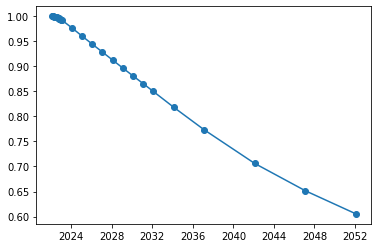

{datetime.date(2022, 1, 31): 1.0,
 datetime.date(2022, 3, 4): 0.9999786669388415,
 datetime.date(2022, 4, 6): 0.9998069902881979,
 datetime.date(2022, 5, 4): 0.9994732208549977,
 datetime.date(2022, 6, 6): 0.9989873617887499,
 datetime.date(2022, 7, 7): 0.9983946450054644,
 datetime.date(2022, 8, 4): 0.9977826707065105,
 datetime.date(2022, 9, 6): 0.9970102585852145,
 datetime.date(2022, 10, 5): 0.9961897388100626,
 datetime.date(2022, 11, 4): 0.9953212354332209,
 datetime.date(2022, 12, 5): 0.9943560235202313,
 datetime.date(2023, 1, 5): 0.993283274024725,
 datetime.date(2023, 2, 6): 0.99216203764081,
 datetime.date(2024, 2, 5): 0.9765340458601712,
 datetime.date(2025, 2, 5): 0.9601210072636603,
 datetime.date(2026, 2, 4): 0.9442242801189423,
 datetime.date(2027, 2, 4): 0.9284011721611023,
 datetime.date(2028, 2, 4): 0.91255671530962,
 datetime.date(2029, 2, 5): 0.8966276034712793,
 datetime.date(2030, 2, 6): 0.8809576995670796,
 datetime.date(2031, 2, 5): 0.8656610593199728,
 datetim

In [5]:
#MyCalendar=USCalendar()
now=datetime.datetime(2022,1,31).date()
MyRatesCurveUSD_SOFR=RatesCurve('USD_SOFR','Act360','LinearOnLogDF',now=now)
MySofrSwap1M=InterestRatesSwapProduct(now=now,name='SOFRSwap1M',Leg1IndexIdentifier='USD_SOFR',
                                 Leg1Tenor=(0,1,0), 
                                 Leg1StartDateLagInDays=2, 
                                 Leg1PaymentLagInDays=2, 
                                 Leg1FloatingRateSpread=0.0, 
                                 Leg1FixedRate=0.0, 
                                 Leg1DayCountConvention='Act360',
                                 Leg1IsFixed=False,
                                 Leg1Frequency='1Y',
                                 Leg2IndexIdentifier='USD_fixed_rate', #инфо
                                 Leg2Tenor=(0,1,0),
                                 Leg2StartDateLagInDays=2,
                                 Leg2PaymentLagInDays=2, #инфо
                                 Leg2FloatingRateSpread=0.0, 
                                 Leg2FixedRate=0.024, 
                                 Leg2DayCountConvention='Act360',
                                 Leg2IsFixed=True,
                                 Leg2Frequency='1Y')



dictSofr={'1M':0.024,'2M':0.107,'3M':0.203,'4M':0.286,'5M':0.369,'6M':0.433,'7M':0.493,'8M':0.558,'9M':0.612,'10M':0.663,
          '11M':0.719,'1Y':0.765,'2Y':1.169,'3Y':1.338,'4Y':1.417,'5Y':1.468,'6Y':1.507,'7Y':1.539,'8Y':1.564,
         '9Y':1.583,'10Y':1.604,'12Y':1.645,'15Y':1.686,'20Y':1.714,'25Y':1.695,'30Y':1.664}
MasSofrSwapNames=['SOFRSwap1M']
MasSofrSwaps=[MySofrSwap1M]
for i in range(2,12):
    #print(dictSofr[str(i)+'M'])
    MySofrSwapiM=MySofrSwap1M.clone(Leg1Tenor=(0,i,0),Leg2Tenor=(0,i,0),Leg2FixedRate=dictSofr[str(i)+'M'],name='SOFRSwap'+str(i)+'M')
    MasSofrSwaps.append(MySofrSwapiM)
    MasSofrSwapNames.append('SOFRSwap'+str(i)+'M')
    
for i in range(1,11):
    MySofrSwapiY=MySofrSwap1M.clone(Leg1Tenor=(0,0,i),Leg2Tenor=(0,0,i),Leg2FixedRate=dictSofr[str(i)+'Y'],name='SOFRSwap'+str(i)+'Y')
    MasSofrSwaps.append(MySofrSwapiY)
    MasSofrSwapNames.append('SOFRSwap'+str(i)+'Y')
    
for i in [12,15,20,25,30]:
    MySofrSwapiY=MySofrSwap1M.clone(Leg1Tenor=(0,0,i),Leg2Tenor=(0,0,i),Leg2FixedRate=dictSofr[str(i)+'Y'],name='SOFRSwap'+str(i)+'Y')
    MasSofrSwaps.append(MySofrSwapiY)
    MasSofrSwapNames.append('SOFRSwap'+str(i)+'Y')

MyMarket=Market(RatesCurves={'USD_SOFR':MyRatesCurveUSD_SOFR},Swaps={a:b for (a,b) in zip(MasSofrSwapNames,MasSofrSwaps)},now=now)
for SwapName in MasSofrSwapNames:
    MyMarket.solve_for_df(now,SwapName)


plt.scatter(MyMarket.RatesCurves['USD_SOFR'].DiscFactors.keys(),MyMarket.RatesCurves['USD_SOFR'].DiscFactors.values())
plt.plot(MyMarket.RatesCurves['USD_SOFR'].DiscFactors.keys(),MyMarket.RatesCurves['USD_SOFR'].DiscFactors.values())
plt.show()
MyMarket.RatesCurves['USD_SOFR'].DiscFactors

# Стороим кривую USD_LIBOR_3M, уже имея дисконтирующую кривую USD_SOFR

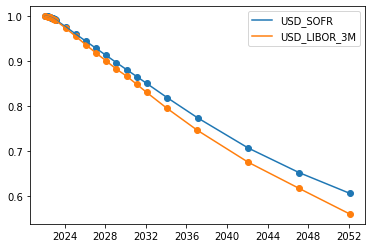

{datetime.date(2022, 1, 31): 1.0,
 datetime.date(2022, 5, 2): 0.9992422342300417,
 datetime.date(2022, 8, 2): 0.9973306834697724,
 datetime.date(2022, 11, 2): 0.9945349350571634,
 datetime.date(2023, 2, 2): 0.9909370481967926,
 datetime.date(2024, 2, 2): 0.9734856467694042,
 datetime.date(2025, 2, 3): 0.9550735272467135,
 datetime.date(2026, 2, 2): 0.9362021744251251,
 datetime.date(2027, 2, 2): 0.9181210519745946,
 datetime.date(2028, 2, 2): 0.9003903057426214,
 datetime.date(2029, 2, 2): 0.8822144143283368,
 datetime.date(2030, 2, 4): 0.8666447756811977,
 datetime.date(2031, 2, 3): 0.8485096540302038,
 datetime.date(2032, 2, 2): 0.8300882671028377,
 datetime.date(2034, 2, 2): 0.7946747891604904,
 datetime.date(2037, 2, 2): 0.7456144481897355,
 datetime.date(2042, 2, 3): 0.6745572717860342,
 datetime.date(2047, 2, 4): 0.6164654564112425,
 datetime.date(2052, 2, 2): 0.5593541905283929}

In [6]:
MyRatesCurveUSD_LIBOR_3M=RatesCurve('USD_LIBOR_3M','Act360','LinearOnLogDF',now=now)
MyUSDLIBORDeposit3M=InterestRatesSwapProduct(now=now,name='USDLIBORDeposit3M',Leg1IndexIdentifier='USD_LIBOR_3M',
                                 Leg1Tenor=(0,3,0), 
                                 Leg1StartDateLagInDays=2, 
                                 Leg1PaymentLagInDays=0, 
                                 Leg1FloatingRateSpread=0.0, 
                                 Leg1FixedRate=0.0, 
                                 Leg1DayCountConvention='Act360',
                                 Leg1IsFixed=False,
                                 Leg1Frequency='3M',
                                 Leg2IndexIdentifier='USD_fixed_rate', #инфо
                                 Leg2Tenor=(0,3,0),
                                 Leg2StartDateLagInDays=2,
                                 Leg2PaymentLagInDays=0, #инфо
                                 Leg2FloatingRateSpread=0.0, 
                                 Leg2FixedRate=0.3, 
                                 Leg2DayCountConvention='Act360',
                                 Leg2IsFixed=True,
                                 Leg2Frequency='3M')

dictUSDLIBOR3M={'1Y':0.9,'2Y':1.33,'3Y':1.53,'4Y':1.63,'5Y':1.69,'6Y':1.73,'7Y':1.77,'8Y':1.8,
         '9Y':1.82,'10Y':1.84,'12Y':1.89,'15Y':1.93,'20Y':1.96,'25Y':1.95,'30Y':1.92}

MyUSDLIBORFRA3M6M=MyUSDLIBORDeposit3M.clone(Leg1Tenor=(0,6,0),Leg2Tenor=(0,6,0),Leg2FixedRate=0.75,Leg1Frequency='3M',Leg2Frequency='3M',name='USDLIBORFRA3M6M')
MyUSDLIBORFRA3M6M.Leg1PeriodStartDates.pop(0)
MyUSDLIBORFRA3M6M.Leg1PeriodEndDates.pop(0)
MyUSDLIBORFRA3M6M.Leg1PaymentDates.pop(0)
MyUSDLIBORFRA3M6M.Leg2PeriodStartDates.pop(0)
MyUSDLIBORFRA3M6M.Leg2PeriodEndDates.pop(0)
MyUSDLIBORFRA3M6M.Leg2PaymentDates.pop(0)


MyUSDLIBORFRA6M9M=MyUSDLIBORDeposit3M.clone(Leg1Tenor=(0,9,0),Leg2Tenor=(0,9,0),Leg2FixedRate=1.1,Leg1Frequency='3M',Leg2Frequency='3M',name='USDLIBORFRA6M9M')
MyUSDLIBORFRA6M9M.Leg1PeriodStartDates.pop(0)
MyUSDLIBORFRA6M9M.Leg1PeriodEndDates.pop(0)
MyUSDLIBORFRA6M9M.Leg1PaymentDates.pop(0)
MyUSDLIBORFRA6M9M.Leg2PeriodStartDates.pop(0)
MyUSDLIBORFRA6M9M.Leg2PeriodEndDates.pop(0)
MyUSDLIBORFRA6M9M.Leg2PaymentDates.pop(0)

MyUSDLIBORFRA6M9M.Leg1PeriodStartDates.pop(0)
MyUSDLIBORFRA6M9M.Leg1PeriodEndDates.pop(0)
MyUSDLIBORFRA6M9M.Leg1PaymentDates.pop(0)
MyUSDLIBORFRA6M9M.Leg2PeriodStartDates.pop(0)
MyUSDLIBORFRA6M9M.Leg2PeriodEndDates.pop(0)
MyUSDLIBORFRA6M9M.Leg2PaymentDates.pop(0)


MasUSDLIBOR3MSwapNames=['USDLIBORDeposit3M','USDLIBORFRA3M6M','USDLIBORFRA6M9M']
MasUSDLIBOR3MSwaps=[MyUSDLIBORDeposit3M,MyUSDLIBORFRA3M6M,MyUSDLIBORFRA6M9M]

for i in range(1,11):
    MyUSDLIBOR3MSwapiY=MyUSDLIBORDeposit3M.clone(Leg1Tenor=(0,0,i),Leg2Tenor=(0,0,i),Leg2FixedRate=dictUSDLIBOR3M[str(i)+'Y'],Leg1Frequency='3M',Leg2Frequency='1Y',name='USDLIBOR3MSwap'+str(i)+'Y')
    MasUSDLIBOR3MSwaps.append(MyUSDLIBOR3MSwapiY)
    MasUSDLIBOR3MSwapNames.append('USDLIBOR3MSwap'+str(i)+'Y')
    
for i in [12,15,20,25,30]:
    MyUSDLIBOR3MSwapiY=MyUSDLIBORDeposit3M.clone(Leg1Tenor=(0,0,i),Leg2Tenor=(0,0,i),Leg2FixedRate=dictUSDLIBOR3M[str(i)+'Y'],Leg1Frequency='3M',Leg2Frequency='1Y',name='USDLIBOR3MSwap'+str(i)+'Y')
    MasUSDLIBOR3MSwaps.append(MyUSDLIBOR3MSwapiY)
    MasUSDLIBOR3MSwapNames.append('USDLIBOR3MSwap'+str(i)+'Y')
    

MyMarket2=Market(RatesCurves={'USD_SOFR':MyMarket.RatesCurves['USD_SOFR'], 'USD_LIBOR_3M':MyRatesCurveUSD_LIBOR_3M},Swaps={a:b for (a,b) in zip(MasUSDLIBOR3MSwapNames,MasUSDLIBOR3MSwaps)},now=now)
for SwapName in MasUSDLIBOR3MSwapNames:
    MyMarket2.solve_for_df(now,SwapName)


plt.scatter(MyMarket.RatesCurves['USD_SOFR'].DiscFactors.keys(),MyMarket.RatesCurves['USD_SOFR'].DiscFactors.values())
plt.plot(MyMarket.RatesCurves['USD_SOFR'].DiscFactors.keys(),MyMarket.RatesCurves['USD_SOFR'].DiscFactors.values(),label='USD_SOFR')
plt.scatter(MyMarket2.RatesCurves['USD_LIBOR_3M'].DiscFactors.keys(),MyMarket2.RatesCurves['USD_LIBOR_3M'].DiscFactors.values())
plt.plot(MyMarket2.RatesCurves['USD_LIBOR_3M'].DiscFactors.keys(),MyMarket2.RatesCurves['USD_LIBOR_3M'].DiscFactors.values(),label='USD_LIBOR_3M')
plt.legend()
plt.show()
MyMarket2.RatesCurves['USD_LIBOR_3M'].DiscFactors



# Стороим кривую USD_LIBOR_6M, уже имея дисконтирующую кривую USD_SOFR и кривую USD_LIBOR_3M

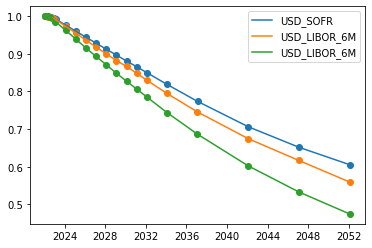

{datetime.date(2022, 1, 31): 1.0,
 datetime.date(2022, 8, 2): 0.9978763280436396,
 datetime.date(2023, 2, 2): 0.9854529123753311,
 datetime.date(2024, 2, 2): 0.9627627981826663,
 datetime.date(2025, 2, 3): 0.9390788331627846,
 datetime.date(2026, 2, 2): 0.9157150747254492,
 datetime.date(2027, 2, 2): 0.8930861433967949,
 datetime.date(2028, 2, 2): 0.8710166892036795,
 datetime.date(2029, 2, 2): 0.8487253712490201,
 datetime.date(2030, 2, 4): 0.8272911366075278,
 datetime.date(2031, 2, 3): 0.8064497105777264,
 datetime.date(2032, 2, 2): 0.7855119723826649,
 datetime.date(2034, 2, 2): 0.7437425073236228,
 datetime.date(2037, 2, 2): 0.6863624721765518,
 datetime.date(2042, 2, 3): 0.6021334782242774,
 datetime.date(2047, 2, 4): 0.532728469464928,
 datetime.date(2052, 2, 2): 0.47440766803920265}

In [12]:
MyRatesCurveUSD_LIBOR_6M=RatesCurve('USD_LIBOR_6M','Act360','LinearOnLogDF',now=now)
MyUSDLIBORDeposit6M=InterestRatesSwapProduct(now=now,name='USDLIBORDeposit6M',
                                 Leg1IndexIdentifier='USD_LIBOR_6M',
                                 Leg1Tenor=(0,6,0), 
                                 Leg1StartDateLagInDays=2, 
                                 Leg1PaymentLagInDays=0, 
                                 Leg1FloatingRateSpread=0.0, 
                                 Leg1FixedRate=0.0, 
                                 Leg1DayCountConvention='Act360',
                                 Leg1IsFixed=False,
                                 Leg1Frequency='6M',
                                 Leg2IndexIdentifier='USD_LIBOR_3M', #инфо
                                 Leg2Tenor=(0,3,0),
                                 Leg2StartDateLagInDays=2,
                                 Leg2PaymentLagInDays=0, #инфо
                                 Leg2FloatingRateSpread=0.55, 
                                 Leg2FixedRate=0.0, 
                                 Leg2DayCountConvention='Act360',
                                 Leg2IsFixed=False,
                                 Leg2Frequency='3M')

dictUSDLIBOR6M={'1Y':3, '18M':4,'2Y':6,'3Y':10,'4Y':11,'5Y':12,'6Y':13,'7Y':14,'8Y':14.5,
         '9Y':15,'10Y':15.25,'12Y':15.5,'15Y':15.75,'20Y':16,'25Y':16.25,'30Y':16.5}



MasUSDLIBOR6MSwapNames=['USDLIBORDeposit6M']
MasUSDLIBOR6MSwaps=[MyUSDLIBORDeposit6M]

for i in range(1,2):
    MyUSDLIBOR6MSwapiY=MyUSDLIBORDeposit6M.clone(Leg1Tenor=(0,0,i),Leg2Tenor=(0,0,i),Leg2FloatingRateSpread=dictUSDLIBOR6M[str(i)+'Y'],Leg1Frequency='6M',Leg2Frequency='3M',name='USDLIBOR6MSwap'+str(i)+'Y')
    MasUSDLIBOR6MSwaps.append(MyUSDLIBOR6MSwapiY)
    MasUSDLIBOR6MSwapNames.append('USDLIBOR6MSwap'+str(i)+'Y')
    
MyUSDLIBOR6MSwap18M=MyUSDLIBORDeposit6M.clone(Leg1Tenor=(0,6,1),Leg2Tenor=(0,6,1),Leg2FloatingRateSpread=dictUSDLIBOR6M['18M'],Leg1Frequency='6M',Leg2Frequency='3M',name='USDLIBOR6MSwap18M')
MasUSDLIBOR6MSwaps.append(MyUSDLIBOR6MSwapiY)
MasUSDLIBOR6MSwapNames.append('USDLIBOR6MSwap18M')

for i in range(2,11):
    MyUSDLIBOR6MSwapiY=MyUSDLIBORDeposit6M.clone(Leg1Tenor=(0,0,i),Leg2Tenor=(0,0,i),Leg2FloatingRateSpread=dictUSDLIBOR6M[str(i)+'Y'],Leg1Frequency='6M',Leg2Frequency='3M',name='USDLIBOR6MSwap'+str(i)+'Y')
    MasUSDLIBOR6MSwaps.append(MyUSDLIBOR6MSwapiY)
    MasUSDLIBOR6MSwapNames.append('USDLIBOR6MSwap'+str(i)+'Y')
    
for i in [12,15,20,25,30]:
    MyUSDLIBOR6MSwapiY=MyUSDLIBORDeposit6M.clone(Leg1Tenor=(0,0,i),Leg2Tenor=(0,0,i),Leg2FloatingRateSpread=dictUSDLIBOR6M[str(i)+'Y'],Leg1Frequency='6M',Leg2Frequency='3M',name='USDLIBOR6MSwap'+str(i)+'Y')
    MasUSDLIBOR6MSwaps.append(MyUSDLIBOR6MSwapiY)
    MasUSDLIBOR6MSwapNames.append('USDLIBOR6MSwap'+str(i)+'Y')
    

MyMarket3=Market(RatesCurves={'USD_SOFR':MyMarket.RatesCurves['USD_SOFR'], 'USD_LIBOR_3M':MyMarket2.RatesCurves['USD_LIBOR_3M'], 'USD_LIBOR_6M':MyRatesCurveUSD_LIBOR_6M},Swaps={a:b for (a,b) in zip(MasUSDLIBOR6MSwapNames,MasUSDLIBOR6MSwaps)},now=now)
for SwapName in MasUSDLIBOR6MSwapNames:
    MyMarket3.solve_for_df(now,SwapName)


plt.scatter(MyMarket.RatesCurves['USD_SOFR'].DiscFactors.keys(),MyMarket.RatesCurves['USD_SOFR'].DiscFactors.values())
plt.plot(MyMarket.RatesCurves['USD_SOFR'].DiscFactors.keys(),MyMarket.RatesCurves['USD_SOFR'].DiscFactors.values(),label='USD_SOFR')
plt.scatter(MyMarket2.RatesCurves['USD_LIBOR_3M'].DiscFactors.keys(),MyMarket2.RatesCurves['USD_LIBOR_3M'].DiscFactors.values())
plt.plot(MyMarket2.RatesCurves['USD_LIBOR_3M'].DiscFactors.keys(),MyMarket2.RatesCurves['USD_LIBOR_3M'].DiscFactors.values(),label='USD_LIBOR_6M')
plt.scatter(MyMarket3.RatesCurves['USD_LIBOR_6M'].DiscFactors.keys(),MyMarket3.RatesCurves['USD_LIBOR_6M'].DiscFactors.values())
plt.plot(MyMarket3.RatesCurves['USD_LIBOR_6M'].DiscFactors.keys(),MyMarket3.RatesCurves['USD_LIBOR_6M'].DiscFactors.values(),label='USD_LIBOR_6M')
plt.legend()
plt.show()
MyMarket3.RatesCurves['USD_LIBOR_6M'].DiscFactors




In [67]:
class VolSmile:
    def __init__(self, Strikes,Vols):
        self.Strikes=np.array(Strikes)/100
        self.Vols=np.array(Vols)/100
    def getvol(self,s):
        if (s<self.Strikes[0] or s>self.Strikes[-1]):
            #print('Extrapolation, Linear')
            return np.sqrt(np.interp(s,self.Strikes, self.Vols**2))
            
        else:
            #print("Interpolation, Cubic")
            spline=CubicSpline(self.Strikes, self.Vols**2, bc_type='natural')
            return np.sqrt(spline(s))
        
def PVExpectation(t,T,tau,F,K,sigma):
    d=(F-K)/sigma/np.sqrt(T-t)
    return sigma*np.sqrt(T-t)*(d*norm.cdf(d)+norm.pdf(d))
        
MyCalendar=USCalendar()
Tdate=MyCalendar.add(now, years=2)
Tptaudate=MyCalendar.add(Tdate, months=6)
tdate=now
tau=(Tptaudate-Tdate).days/360
T=(Tdate-now).days/360
t=0
K=3/100
FtTTptau=(MyMarket3.RatesCurves['USD_LIBOR_6M'].get_disc_factor_t_T(now,Tdate)/MyMarket3.RatesCurves['USD_LIBOR_6M'].get_disc_factor_t_T(now,Tptaudate)-1)/tau

Strikes=[0.25,0.5,0.75,1,1.5,2,2.5,3,4,5,6,7,8,9,10,12,15] #in persent
Vols=[42,38,35,32,29.5,28.3,27.7,27.5,27.7,28.5,30,32,34,36,38,41,43] #in persent
MyVolSmile=VolSmile(Strikes, Vols)
PVcaplet=PVExpectation(t,T,tau,FtTTptau,K,MyVolSmile.getvol(K))
summa_integrala=0
for k in np.linspace(K,30/100, 10000):
    #print("k=",k, PVExpectation(t,T,tau,FtTTptau,k,MyVolSmile.getvol(k)))
    summa_integrala+=PVExpectation(t,T,tau,FtTTptau,k,MyVolSmile.getvol(k))*(30/100-K)/10000

df0Tptau=MyMarket3.RatesCurves['USD_LIBOR_6M'].get_disc_factor_t_T(now,Tptaudate)
PVcaplet_inarrears=df0Tptau*tau*((1+K)*PVExpectation(t,T,tau,FtTTptau,K,MyVolSmile.getvol(K))+2*summa_integrala)
PVCaplet=df0Tptau*tau*PVExpectation(t,T,tau,FtTTptau,K,MyVolSmile.getvol(K))
print("PVcaplet=",PVcaplet)
print("PVcaplet_inarrears=",PVcaplet_inarrears)

PVcaplet= 0.1535248274894729
PVcaplet_inarrears= 0.11851554963232741
